## Simulated Correlated Time Series

To test the efficacy of Triple Collocation (TC), we have simulated a correlated time series using the [CoSMoS](https://cran.r-project.org/web/packages/CoSMoS/vignettes/vignette.html) package in R (see [simulation.R](R/simulation.R)). The package uses spatiotemporal correlation structures to generate a time series correlated in time and space. We have chosen to use the Clayton-Weibull spatiotemporal correlation structure, which has correlations exponentially decrease as elements in the series increase in separation in space and time. This is given by

$\rho_{\rm CW}(\delta, \tau) = \Big(\exp\Big(\theta\Big(\frac{\delta}{b_{\rm S}}\Big)^{c_{\rm S}}\Big) + \exp\Big(\theta\Big(\frac{\tau}{b_{\rm T}}\Big)^{c_{\rm T}}\Big) - 1 \Big)^{-\frac{1}{\theta}}$,

where $\rho_{\rm CW}$ is the correlation structure, $\delta$ is space, $\tau$ is time, $\theta$ is the copula parameter, $b_{\rm S}$ and $b_{\rm T}$ are the space and time scale parameters, and $c_{\rm S}$ and $c_{\rm T}$ are the space and time shape parameters, respectfully. Since we look at the time series of each spatial pixel individually, this leads to $\delta = 0$, which simplifies the CW equation to

$\rho_{\rm CW}(\tau) = \Big(\exp\Big(\theta\Big(\frac{\tau}{b_{\rm T}}\Big)^{c_{\rm T}}\Big)\Big)^{-\frac{1}{\theta}}$.

In [1]:
def cw_stcs(tau, theta, bt, ct):
    import numpy as np
    
    rho = (np.exp(theta * (tau / bt) ** ct)) ** (-1 / theta)
    return rho

Additionally, the maginal distribution from which to sample was chosen to be a normal distribution. We then ran the simulation three independent times for a 20x20 grid of spatial points and 5000 temporal points. Each of the three simulations utilized different normal distribution shape properties (i.e., mean and variance). Finally, we saved the output (which were matrices in R) from [CoSMoS](https://cran.r-project.org/web/packages/CoSMoS/vignettes/vignette.html) to a hdf5 file for use in this notebook.

In [2]:
import h5py
import numpy as np

f = h5py.File('../Data/simulation.hdf5', "r")
# The parameter names indicate each maginal distributions variance (i.e., 3, 2, 1.5)
sim3 = np.array(f['sim3'])
sim2 = np.array(f['sim2'])
sim15 = np.array(f['sim15'])

print(sim15.shape, sim2.shape, sim3.shape)

# Let's stack the three different simulations along a third dimension and adjust dimensions
#   to have ndata x nsim x npix
sim = np.stack((sim15, sim2, sim3), axis=2).transpose((1, 2, 0))
print(sim.shape)

(400, 5000) (400, 5000) (400, 5000)
(5000, 3, 400)


Now that we have read in the simulated data, let's estimate the error variances using TC. Since [Zwieback+2014](https://npg.copernicus.org/articles/19/69/2012/) showed that we only need 500 or so samples to estimate the variances within 10%, we will compute the variances for our simulations using 500 up to 5000 samples to see if including more samples makes a significant difference.

> Note that we will use the multi-dimensional EC function to do this. As shown in the [random dataset example](Examples/random_dataset.ipynb), the EC function is equivalent to using the TC function if only three datasets are used. Therefore by using the multi-dimensional EC function, it will be much faster since it parallelizes along the spatial dimensions.

In [3]:
%run ../TC/EC_function.ipynb

In [4]:
# It takes a while to run all 400 pixels. So, we just do the first 100.
evar = np.zeros((3, 100, 4500))
for i in range(500, 5000):
    # Only need the diagonal, so extract it
    evar[:, :, i-500] = np.diagonal(ec_covar_multi(sim[0:i, :, 0:100], corr_sets=[1, 2, 3])).T

Now, let's plot this to see if the variances are estimated well and if including more samples improves our esimates.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
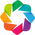

:Overlay
   .Curve.I       :Curve   [x]   (y)
   .Curve.J       :Curve   [x]   (y)
   .Curve.K       :Curve   [x]   (y)
   .Curve.I_Truth :Curve   [x]   (y)
   .Curve.J_Truth :Curve   [x]   (y)
   .Curve.K_Truth :Curve   [x]   (y)

In [5]:
import holoviews as hv
hv.extension('bokeh')

fig_samplesi = hv.Curve(zip(np.arange(500, 5000), np.nanmedian(evar[0, :, :], axis=0)), label='i').opts(color='green',height=300, width=800, 
                                                                              xlabel='Number of Samples', ylabel='Estimated Error Variance', xlim=(500, 5700), ylim=(0.08, 0.37))
fig_samplesj = hv.Curve(zip(np.arange(500, 5000), np.nanmedian(evar[1, :, :], axis=0)), label='j').opts(color='orange')
fig_samplesk = hv.Curve(zip(np.arange(500, 5000), np.nanmedian(evar[2, :, :], axis=0)), label='k').opts(color='red')

fig_truthi = hv.Curve(zip([500, 5000], [0.15, 0.15]), label='i Truth').opts(color='lime')
fig_truthj = hv.Curve(zip([500, 5000], [0.2, 0.2]), label='j Truth').opts(color='gold')
fig_truthk = hv.Curve(zip([500, 5000], [0.3, 0.3]), label='k Truth').opts(color='darkred')

display(fig_samplesi * fig_samplesj * fig_samplesk * fig_truthi * fig_truthj * fig_truthk)

So, the estimates align fairly well with the truth values, increasing in agreement as more samples are included as we would expect. Therefore, TC works well at estimating each observation system's error variance, if each system has independent errors.

Now, let's use TC on a simulation where the errors of different observation systems are correlated. To do this, we ran another [CoSMoS](https://cran.r-project.org/web/packages/CoSMoS/vignettes/vignette.html) simulation using the Clayton-Weibull spatiotemporal correlation structure, normal marginalized distribution, 10x10 spatial pixels, and 40000 time steps. To create correlated observational systems from this simulation, we split the simulation into three observation systems. This is done by distributing the first 3 elements in each time series of each pixel (i.e., indices 0, 1, 2) to each observing system. This is then repeated for the next three elements in the time series, and the next three, and so on until each observing system has 500 time elements.

Additionally, to show how decreasing correlation effects the error variance estimates, we can do a similar method of distrubuting the simulated data to each observing system. Instead of the first three elements, we can do every other element till we have three (i.e., indices 0, 2, 4) and repeat till each system has 500 elements. This method can keep being repeated (e.g., indices 0, 3, 6; indices 0, 4, 8, etc.) to make less and less correlated observing systems by continually spreading out the elements distributed to each observing system.

In [6]:
sim_long = np.array(f['sim'])

sim_corr = np.zeros((3, sim_long.shape[0], 500, int(np.floor(sim_long.shape[1]/3/500))))

for i in range(int(np.floor(sim_long.shape[1]/3/500))):
    obs1 = (sim_long[:, slice(0, 500*(i+1)*3, (3*(i+1)))])
    obs2 = (sim_long[:, slice(1*(i+1), 500*(i+1)*3+1*(i+1), 3*(i+1))])
    obs3 = (sim_long[:, slice(2*(i+1), 500*(i+1)*3+2*(i+1), 3*(i+1))])
    sim_corr[:, :, :, i] = np.stack((obs1, obs2, obs3), axis=0)

sim_corr.shape

(3, 100, 500, 26)

Now that we have our correlated observing system data from the simulation, we can estimate the error variances using TC.

In [7]:
evar_corr = np.diagonal(ec_covar_multi(sim_corr.transpose((2, 0, 1, 3)), corr_sets=[1, 2, 3])).transpose((2, 0, 1))
evar_med = np.nanmedian(evar_corr, axis=1)

Using the median error variance of all the pixels, we can plot how the error variance estimates change with decreasing correlation (i.e., increasing separation of distributed time elements). Since we know the temporal distance between each element, we can directly calculate the correlation from the CW function we made earlier using the chosen parameters in the simulation and use this in our plot.

In [8]:
rho = cw_stcs(np.arange(np.floor(sim_long.shape[1]/3/500)) + 1, 2, 3, 0.7)

fig_var_corr_i = hv.Curve(zip(rho, evar_med[0, :]), label='i').opts(color='green', height=300, width=800, xlabel='CW correlation',
                                                                ylabel='Estimated Error Variance', logx=True)
fig_var_corr_j = hv.Curve(zip(rho, evar_med[1, :]), label='j').opts(color='orange')
fig_var_corr_k = hv.Curve(zip(rho, evar_med[2, :]), label='k').opts(color='red')

fig_truth = hv.Curve(zip(rho, np.repeat(0.15, np.floor(sim_long.shape[1]/3/500))), label='Truth').opts(color='black')

display((fig_var_corr_i * fig_var_corr_j * fig_var_corr_k * fig_truth).opts(legend_position='bottom_left'))

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .Curve.J     :Curve   [x]   (y)
   .Curve.K     :Curve   [x]   (y)
   .Curve.Truth :Curve   [x]   (y)

As we can see, the decrease in correlation (increase distance between distributed points) between observing systems results in error variance estimates that are closer to the truth values. Notice that $i$ and $k$ result in better estimates of the error variance at higher correlations compared to $j$. Since correlation is between pairs of systems and the simulated data was distributed with $i$ getting the first index, $j$ getting the second index, and $k$ getting the third index; we have the correlation pair of $ik$ having less correlation due to them having double the distance in time. Therefore, $j$ is more highly correlated with both $i$ and $k$ compared to $i$ with $k$. This leads to the less accurate estimates of the error variance in $j$ as seen in the plot.

To ensure our correlations in our simulated data are being calculated from the CW function as we would expect, we can calculate the Pearson correlation and plot it against our derived value from the CW function.

In [9]:
pearson_coef = np.zeros((3, 3, sim_long.shape[0], int(np.floor(sim_long.shape[1]/3/500))))

for i in range(int(np.floor(sim_long.shape[1]/3/500))):
    for j in range(sim_long.shape[0]):
        pearson_coef[:, :, j, i] = np.corrcoef(sim_corr[:, j, :, i])

# Use the median correlation of all pixels
pearson_med = np.median(pearson_coef, axis=2)

In [10]:
rho = cw_stcs(np.stack(((np.arange(np.floor(sim_long.shape[1]/3/500))) + 1, ((np.arange(np.floor(sim_long.shape[1]/3/500))) + 1) * 2), axis=1), 2, 3, 0.7)

fig_corrij = hv.Curve(zip(rho[:, 0], pearson_med[0, 1, :]), label='ij').opts(color='green', height=500, width=500, xlabel='CW correlation',
                                                                ylabel='Estimated Correlation (Pearson)')
fig_corrik = hv.Curve(zip(rho[:, 1], pearson_med[0, 2, :]), label='ik').opts(color='orange')
fig_corrjk = hv.Curve(zip(rho[:, 0], pearson_med[1, 2, :]), label='jk').opts(color='red')

fig_one2one = hv.Curve(zip([0, 0.7], [0, 0.7])).opts(color='black', line_dash='dashed')

display((fig_corrij * fig_corrik * fig_corrjk * fig_one2one).opts(legend_position='bottom_right'))

:Overlay
   .Curve.Ij :Curve   [x]   (y)
   .Curve.Ik :Curve   [x]   (y)
   .Curve.Jk :Curve   [x]   (y)
   .Curve.I  :Curve   [x]   (y)

From this plot, we can see that the correlations are indeed what we are expecting. Therefore, this shows that in order to use TC to get estimates of the error variance we must have observing systems that have errors that are minimally correlated.

Now, let's apply Extended Collocation (EC) to see if adding additional independent data sets allows for us to get better estimates of the error (co)variances when we do have correlation between observing systems.

Since EC requires at least three independent observing systems, we will add two additional independent systems to this previous set of three correlated systems, giving us a total of five systems. Of these five, the two added systems are completely independent of each other and the correlated three, meaning we meet the requirements of at least three independent systems. These two systems will be two of the simulated independent systems from the beginning of this notebook. Therefore, with these two new observing systems, we can better estimated the error variance and covariance of the three correlated systems.

In [11]:
print(sim_corr.shape, sim2.shape, sim3.shape)

(3, 100, 500, 26) (400, 5000) (400, 5000)


In [12]:
sim_EC_corr = np.zeros((5, 100, 500, int(np.floor(sim_long.shape[1]/3/500))))
sim_EC_corr[:3, :, :, :] = sim_corr
sim_EC_corr[3, :, :, :] = sim2[:100, :500].reshape(100, 500, 1).repeat(int(np.floor(sim_long.shape[1]/3/500)), 2)
sim_EC_corr[4, :, :, :] = sim3[:100, :500].reshape(100, 500, 1).repeat(int(np.floor(sim_long.shape[1]/3/500)), 2)

# The first three systems are correlated, so we indicate such by giving each associated index the same value in corr_sets
ecovar = ec_covar_multi(sim_EC_corr.transpose((2, 0, 1, 3)), corr_sets=[0, 0, 0, 1, 2])       
ecovar_med = np.nanmedian(ecovar, axis=2)

print('Estimated values of l for each correlation of ijk (Expected value = 0.2):', ecovar_med[3, 3, :])
print('Estimated values of m for each correlation of ijk (Expected value = 0.3):', ecovar_med[4, 4, :])

Estimated values of l for each correlation of ijk (Expected value = 0.2): [0.1950113  0.19007191 0.19092703 0.19054847 0.19529005 0.19190542
 0.19292116 0.18944645 0.19247102 0.19258428 0.1913141  0.19113628
 0.18911368 0.18856296 0.18884912 0.19271844 0.19341674 0.19065855
 0.19066852 0.19116107 0.19252275 0.19417227 0.18989681 0.19301058
 0.19138944 0.19297353]
Estimated values of m for each correlation of ijk (Expected value = 0.3): [0.35206079 0.34643966 0.34734232 0.34849228 0.35265137 0.35278189
 0.34920946 0.34657559 0.35034793 0.34765409 0.34575214 0.34798784
 0.34730579 0.34595494 0.34777239 0.35089538 0.3535983  0.34218179
 0.35118324 0.34853923 0.35467171 0.35190836 0.34887444 0.34832368
 0.35038934 0.35206251]


From the EC error estimation, we can see that the two independent data sets had their error variances estimated near their expected values. `l` is slightly below the expectation, and `m` is slightly elevated. These biases could be reduced by including more than the 500 samples we are currently using as shown above, but they are close to being within 10% of the expected value. Finally, let's plot the estimated error (co)variances of the three correlated systems versus the CW correlation to check that using EC effectively estimated and accounted for the correlations.

In [13]:
fig_vari = hv.Curve(zip(rho[:, 0], ecovar_med[0, 0, :]), label='i').opts(color='green', height=300, width=800, xlabel='CW correlation',
                                                                ylabel='Estimated Error (Co)Variance', logx=True)
fig_varj = hv.Curve(zip(rho[:, 0], ecovar_med[1, 1, :]), label='j').opts(color='orange')
fig_vark = hv.Curve(zip(rho[:, 0], ecovar_med[2, 2, :]), label='k').opts(color='red')

fig_covij = hv.Curve(zip(rho[:, 0], np.mean([ecovar_med[0, 1, :], ecovar_med[1, 0, :]], axis=0)), label='ij covar').opts(color='green')
fig_covij = fig_covij * hv.Curve(zip(rho[:, 0], np.mean([ecovar_med[0, 1, :], ecovar_med[1, 0, :]], axis=0)), label='ij covar').opts(color='orange', line_dash='dashed')

fig_covik = hv.Curve(zip(rho[:, 1], np.mean([ecovar_med[0, 2, :], ecovar_med[2, 0, :]], axis=0)), label='ik covar').opts(color='green')
fig_covik = fig_covik * hv.Curve(zip(rho[:, 1], np.mean([ecovar_med[0, 2, :], ecovar_med[2, 0, :]], axis=0)), label='ik covar').opts(color='red', line_dash='dashed')

fig_covjk = hv.Curve(zip(rho[:, 0], np.mean([ecovar_med[1, 2, :], ecovar_med[2, 1, :]], axis=0)), label='jk covar').opts(color='orange')
fig_covjk = fig_covjk * hv.Curve(zip(rho[:, 0], np.mean([ecovar_med[1, 2, :], ecovar_med[2, 1, :]], axis=0)), label='jk covar').opts(color='red', line_dash='dashed')

fig_truth = hv.Curve(zip(rho[:, 0], np.repeat(0.15, np.floor(sim_long.shape[1]/3/500))), label='Var Truth').opts(color='black')
fig_truthcov = hv.Curve(zip(np.sort(rho.flatten()), np.sort(rho.flatten()) * 0.15), label='Covar Truth').opts(color='black', line_dash='dashed')

display((fig_vari * fig_varj * fig_vark * fig_truth * fig_covij * fig_covik * fig_covjk * fig_truthcov).opts(legend_position='top_left'))

:Overlay
   .Curve.I           :Curve   [x]   (y)
   .Curve.J           :Curve   [x]   (y)
   .Curve.K           :Curve   [x]   (y)
   .Curve.Var_Truth   :Curve   [x]   (y)
   .Curve.Ij_covar.I  :Curve   [x]   (y)
   .Curve.Ij_covar.II :Curve   [x]   (y)
   .Curve.Ik_covar.I  :Curve   [x]   (y)
   .Curve.Ik_covar.II :Curve   [x]   (y)
   .Curve.Jk_covar.I  :Curve   [x]   (y)
   .Curve.Jk_covar.II :Curve   [x]   (y)
   .Curve.Covar_Truth :Curve   [x]   (y)

Great! So, EC appropriately accounted for the correlations and estimated the error (co)variances accurately. Therefore, correlations in the errors can be present in the data sets as long as at least three observing systems are not correlated.